In [81]:
import sys

# !{sys.executable} -m pip install spotipy --upgrade
# !{sys.executable} -m pip install scikit-learn -q
# !{sys.executable} -m pip install ipyplot -q
# !{sys.executable} -m pip install umap-learn -q
# !{sys.executable} -m pip install statsmodels -q
!{sys.executable} -m pip install pytest -q

In [44]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import os
import pandas as pd
from warnings import filterwarnings

from dotenv import load_dotenv

from IPython.display import Image, display
from IPython.core.display import HTML
import ipyplot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import umap
import numpy as np

load_dotenv()
filterwarnings("ignore")
pd.set_option("display.max_columns", 10)
SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")
SPOTIFY_PLAYLIST_IDS = os.getenv("SPOTIFY_PLAYLIST_IDS")

sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET
    )
)

# Get Tracks

In [6]:
tracks_df = pd.DataFrame()
max_limit = 100

for p_id in playlist_ids:
    total_items = sp.playlist_tracks(playlist_id=p_id, offset=0, limit=1).get("total")
    batch = total_items // max_limit
    for b in range(batch + 1):
        items = sp.playlist_tracks(
            playlist_id=p_id, offset=b * max_limit, limit=max_limit
        ).get("items")
        for i in items:
            for a in i.get("track").get("artists"):
                tracks_df = tracks_df.append(
                    {
                        "playlist_id": p_id,
                        "date": i.get("added_at"),
                        "track_id": i.get("track").get("id"),
                        "track_name": i.get("track").get("name"),
                        "image_url": i.get("track")
                        .get("album")
                        .get("images")[0]
                        .get("url"),
                        "artist_id": a.get("id"),
                        "artist_name": a.get("name"),
                    },
                    ignore_index=True,
                )
print(tracks_df.shape)
tracks_df.tail()

(128, 7)


,playlist_id,date,track_id,track_name,image_url,artist_id,artist_name
123,1PGA7tTmbEwCE5n7I1ygGS,2023-01-15T00:53:21Z,37Tmv4NnfQeb0ZgUC4fOJj,Sultans Of Swing,https://i.scdn.co/image/ab67616d0000b2739dfee5...,0WwSkZ7LtFUFjGjMZBMt6T,Dire Straits
124,1PGA7tTmbEwCE5n7I1ygGS,2023-01-15T00:55:00Z,6QewNVIDKdSl8Y3ycuHIei,Even Flow,https://i.scdn.co/image/ab67616d0000b273d400d2...,1w5Kfo2jwwIPruYS2UWh56,Pearl Jam
125,1PGA7tTmbEwCE5n7I1ygGS,2023-02-01T04:28:41Z,7uIF6RDrW2PwvvYEMkanr8,Bad Company,https://i.scdn.co/image/ab67616d0000b273cd626f...,5t28BP42x2axFnqOOMg3CM,Five Finger Death Punch
126,1PGA7tTmbEwCE5n7I1ygGS,2023-02-12T12:49:31Z,0gMTjqQCHmQpCqmmeCy2wP,Wrong Side of Heaven,https://i.scdn.co/image/ab67616d0000b273d7ad34...,5t28BP42x2axFnqOOMg3CM,Five Finger Death Punch
127,1PGA7tTmbEwCE5n7I1ygGS,2023-02-28T12:36:43Z,4IoYz8XqqdowINzfRrFnhi,You Found Me,https://i.scdn.co/image/ab67616d0000b27392b324...,0zOcE3mg9nS6l3yxt1Y0bK,The Fray


# Get Genres

In [7]:
genres = []
for a in tracks_df.artist_id:
    try:
        g = sp.artist(f"https://open.spotify.com/artist/{a}").get("genres")
    except:
        g = []
    genres.append(g)
tracks_df["genres"] = genres
tracks_df.tail()

,playlist_id,date,track_id,track_name,image_url,artist_id,artist_name,genres
123,1PGA7tTmbEwCE5n7I1ygGS,2023-01-15T00:53:21Z,37Tmv4NnfQeb0ZgUC4fOJj,Sultans Of Swing,https://i.scdn.co/image/ab67616d0000b2739dfee5...,0WwSkZ7LtFUFjGjMZBMt6T,Dire Straits,"[album rock, classic rock, mellow gold, rock, ..."
124,1PGA7tTmbEwCE5n7I1ygGS,2023-01-15T00:55:00Z,6QewNVIDKdSl8Y3ycuHIei,Even Flow,https://i.scdn.co/image/ab67616d0000b273d400d2...,1w5Kfo2jwwIPruYS2UWh56,Pearl Jam,"[grunge, permanent wave, rock]"
125,1PGA7tTmbEwCE5n7I1ygGS,2023-02-01T04:28:41Z,7uIF6RDrW2PwvvYEMkanr8,Bad Company,https://i.scdn.co/image/ab67616d0000b273cd626f...,5t28BP42x2axFnqOOMg3CM,Five Finger Death Punch,"[alternative metal, groove metal, nu metal]"
126,1PGA7tTmbEwCE5n7I1ygGS,2023-02-12T12:49:31Z,0gMTjqQCHmQpCqmmeCy2wP,Wrong Side of Heaven,https://i.scdn.co/image/ab67616d0000b273d7ad34...,5t28BP42x2axFnqOOMg3CM,Five Finger Death Punch,"[alternative metal, groove metal, nu metal]"
127,1PGA7tTmbEwCE5n7I1ygGS,2023-02-28T12:36:43Z,4IoYz8XqqdowINzfRrFnhi,You Found Me,https://i.scdn.co/image/ab67616d0000b27392b324...,0zOcE3mg9nS6l3yxt1Y0bK,The Fray,"[neo mellow, piano rock, pop, pop rock]"


# Get Features

In [8]:
features = []
for t in tracks_df.track_id:
    features.append(sp.audio_features(t)[0])
audio_features = [
    "id",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
features = pd.DataFrame.from_dict(features)[audio_features].set_index("id")
features.head()

,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo
id,,,,,,,,,,,
2hl6XZ8nztFfVDv2qHPnwt,0.400,0.914,8,-3.669,1,...,0.489000,0.012000,0.0588,0.843,85.444
7Dm3dV3WPNdTgxoNY7YFnc,0.522,0.755,9,-6.950,1,...,0.051700,0.000066,0.0781,0.637,151.796
0ofHAoxe9vBkTCp2UQIavz,0.828,0.492,0,-9.744,1,...,0.064400,0.004280,0.1280,0.789,120.151
0U6Ga0VWSGq6iEE1AKkgO1,0.730,0.487,4,-10.991,1,...,0.258000,0.010000,0.0852,0.731,114.965
1Vb1iR09yHdwLO7Z7YSKcg,0.452,0.752,5,-6.449,0,...,0.000131,0.864000,0.6910,0.507,113.149


In [24]:
tracks_df.to_parquet(f"data/tracks.parquet")
features.to_parquet(f"data/features.parquet")

# Cluster

In [71]:
s_features = MinMaxScaler().fit_transform(features)
clusterable_embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=69,
).fit_transform(s_features)

# model = DBSCAN(min_samples=10).fit(s_features)
# model  = KMeans(n_clusters=3).fit(X=s_features)
model = DBSCAN(min_samples=5).fit(clusterable_embedding)

tracks_df["tracks_segment"] = model.labels_
model.labels_

array([ 0,  0,  1,  1,  2,  0,  0,  2,  0,  0,  2,  3,  2,  2,  0,  0,  0,
        2,  2,  0,  0,  3,  3,  0,  0,  3,  3,  3,  2,  0,  2,  0,  0,  3,
        0,  0,  2,  2,  0,  0,  3,  2,  0,  1,  1,  0,  0,  3,  0,  0,  2,
        1,  0,  0,  2,  2, -1,  0,  0,  2,  2,  2,  3,  2,  2,  3,  0,  1,
        0,  3,  0,  1,  0,  0,  2,  2,  0,  0,  0,  0,  0,  3,  2,  0,  2,
        0,  0,  0,  0,  3,  3,  2,  0,  0,  0,  3,  0,  2,  0,  0,  0,  0,
        0,  0,  2,  3,  0,  1,  2,  3,  0,  2,  0,  1,  2,  2,  2,  2,  0,
        0,  3,  0,  2,  0,  2,  2,  2,  2])

## Postprocess

In [72]:
tracks_df["tracks_segment"] = tracks_df["tracks_segment"].apply(
    lambda x: 99 if x == -1 else x
)

# artists
segments = (
    tracks_df.groupby(["tracks_segment", "artist_name"])["track_id"]
    .count()
    .reset_index()
    .sort_values(by="track_id", ascending=False)
)
segments["total_tracks"] = (
    segments["track_id"].groupby(segments["artist_name"]).transform("sum")
)
segments["pct_tracks"] = segments["track_id"] / segments["total_tracks"]
segments = segments[segments.total_tracks >= 2].sort_values(
    by="pct_tracks", ascending=False
)

# genres
cols_g = ["track_id", "genres", "tracks_segment", "artist_name"]
genres_df = tracks_df.copy()[cols_g]
genres_df = genres_df.explode("genres")
segments_genres = (
    genres_df.groupby(["tracks_segment", "genres"])["track_id"].count().reset_index()
)
segments_genres["total_tracks"] = (
    segments_genres["track_id"].groupby(segments_genres["genres"]).transform("sum")
)
segments_genres["pct_tracks"] = (
    segments_genres["track_id"] / segments_genres["total_tracks"]
)
segments_genres = segments_genres[segments_genres.total_tracks >= 3].sort_values(
    by="pct_tracks", ascending=False
)

# timeseries
cols_t = ["date", "track_id", "tracks_segment"]
segment_times = tracks_df[cols_t].copy()
segment_times["date"] = pd.to_datetime(segment_times["date"]).dt.strftime("%Y-%m-01")
segment_times["tracks_segment"] = segment_times["tracks_segment"].astype(str)
segment_times = (
    segment_times.groupby(["tracks_segment", "date"]).track_id.count().reset_index()
)
segment_times["cum_segment_tracks"] = segment_times.groupby(["tracks_segment"])[
    "track_id"
].cumsum()
segment_times["max_segment_tracks"] = (
    segment_times["cum_segment_tracks"]
    .groupby(segment_times["tracks_segment"])
    .transform("max")
)
segment_times["cum_pct_tracks"] = (
    segment_times["cum_segment_tracks"] / segment_times["max_segment_tracks"]
)

# images
cols_i = ["track_id", "track_name", "tracks_segment", "artist_name", "image_url"]
images_df = tracks_df[cols_i].drop_duplicates().copy()
images_df["text"] = images_df["artist_name"] + ": " + images_df["track_name"]

## Visualize

Segment Profile
0: ['Poison', 'Radiohead', 'Joan Jett & the Blackhearts', "Guns N' Roses", 'Dire Straits', 'Red Hot Chili Peppers', 'AC/DC', 'Linkin Park', 'Pink Floyd', 'Fleetwood Mac']
0: ['funk metal', 'glam metal', 'art rock', 'funk rock', 'modern rock', 'mellow gold', 'hard rock', 'permanent wave', 'alternative rock', 'album rock']
1: ['Fleetwood Mac']
1: ['yacht rock', 'soft rock']
2: ['Five Finger Death Punch', 'Metallica', 'Fleetwood Mac']
2: ['old school thrash', 'thrash metal', 'metal', 'yacht rock', 'classic rock', 'alternative metal', 'hard rock', 'nu metal', 'rock', 'soft rock']
3: ['Creed', 'Mumford & Sons', 'Linkin Park']
3: ['post-grunge', 'nu metal', 'alternative metal', 'pop rock', 'permanent wave']


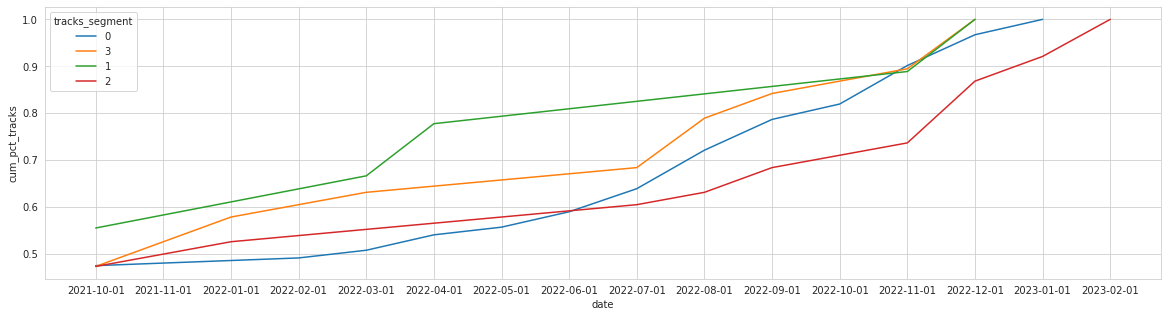

In [143]:
print("\x1b[1;31m" + "Segment Profile" + "\x1b[0m")

clusters = set(segments.tracks_segment.unique())
clusters.remove(99)
for i in clusters:
    a = list(
        segments[
            (segments.tracks_segment == i)
            & (segments.pct_tracks >= 0.2)
            & (segments.track_id > 1)
        ]
        .head(10)
        .artist_name.unique()
    )
    print(f"{i}: {a}")
    g = list(
        segments_genres[
            (segments_genres.tracks_segment == i)
            & (segments_genres.pct_tracks >= 0.2)
            & (segments_genres.track_id > 3)
        ]
        .head(10)
        .genres.unique()
    )
    print(f"{i}: {g}")

plt.figure(figsize=(20, 5))
with sns.axes_style("whitegrid"):
    fig = sns.lineplot(
        x="date",
        y="cum_pct_tracks",
        hue="tracks_segment",
        data=segment_times[segment_times.tracks_segment != "99"].sort_values(by="date"),
    )

ipyplot.plot_class_tabs(
    images_df.image_url,
    images_df.tracks_segment,
    show_url=False,
    custom_texts=images_df.text,
    max_imgs_per_tab=20,
    img_width=150,
)

# Switching Models

In [82]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds

In [129]:
time_df = tracks_df.copy().set_index("track_id")[["date"]]

umap_features = pd.DataFrame(
    clusterable_embedding, index=features.index, columns=["u0", "u1"]
)
features_combined = features.merge(umap_features, left_index=True, right_index=True)

time_df = time_df.merge(features_combined, left_index=True, right_index=True)
time_df["date"] = pd.to_datetime(time_df["date"]).dt.date
time_df.set_index("date", inplace=True)
time_df.sort_values(by="date", inplace=True)
time_df.head()

,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,u0,u1
date,,,,,,,,,,,
2021-10-29,0.590,0.671,9,-6.098,1,...,0.0604,0.438,149.982,11.327816,8.374434
2021-10-29,0.499,0.752,2,-9.549,0,...,0.0874,0.612,94.614,-11.581389,6.635267
2021-10-29,0.512,0.864,7,-4.146,1,...,0.0982,0.527,138.018,10.535661,7.635056
2021-10-29,0.524,0.733,0,-7.390,1,...,0.0860,0.518,144.037,7.731362,6.812328
2021-10-29,0.451,0.951,1,-3.754,1,...,0.2610,0.442,162.065,7.207023,6.607865


/media/starscream/wheeljack1/projects/art/src/music/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                     u0   No. Observations:                  170
Model:               MarkovRegression   Log Likelihood                -334.059
Date:                Sun, 05 Mar 2023   AIC                            678.118
Time:                        17:25:25   BIC                            693.797
Sample:                             0   HQIC                           684.481
                                - 170                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6717      0.127    -91.556      0.000     -11.922     -11.422
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5572      0.089    106.966      0.000       9.382       9.732
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9101      0.099      9.220      0.000       0.717       1.104
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5241      0.067      7.823      0.000       0.393       0.655
p[1->0]        0.2346      0.040      5.922      0.000       0.157       0.312
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

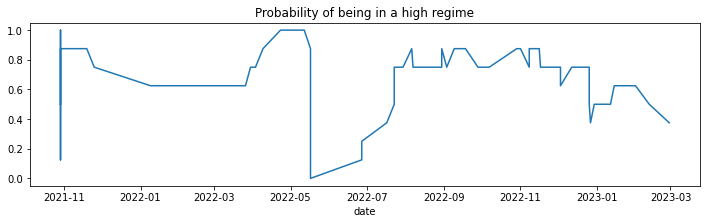

In [142]:
# switching_features = audio_features[1:2]
switching_features = ["u0"]
model_s = sm.tsa.MarkovRegression(time_df[switching_features], k_regimes=2)
residuals_s = model_s.fit()
residuals_s.smoothed_marginal_probabilities[1].rolling(8, min_periods=2).mean().plot(
    title="Probability of being in a high regime", figsize=(12, 3)
)
residuals_s.summary()

/media/starscream/wheeljack1/projects/art/src/music/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                     u1   No. Observations:                  170
Model:               MarkovRegression   Log Likelihood                -255.647
Date:                Sun, 05 Mar 2023   AIC                            521.295
Time:                        17:25:18   BIC                            536.974
Sample:                             0   HQIC                           527.657
                                - 170                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4453        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2477      0.083     86.809      0.000       7.084       7.411
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.1850      0.129      9.220      0.000       0.933       1.437
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     3.768e-05        nan        nan        nan         nan         nan
p[1->0]     1.514e-06        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

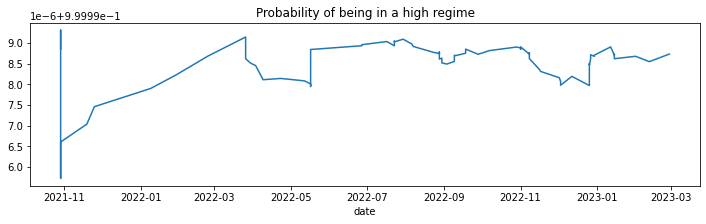

In [141]:
switching_features = ["u1"]
model_s = sm.tsa.MarkovRegression(time_df[switching_features], k_regimes=2)
residuals_s = model_s.fit()
residuals_s.smoothed_marginal_probabilities[1].rolling(8, min_periods=2).mean().plot(
    title="Probability of being in a high regime", figsize=(12, 3)
)
residuals_s.summary()